# Рабочая тетрадь

## по машинному обучению на больших данных

## ученика 4 "В" класса

## НИУ ВШЭ

## Золотарева Антона

Соревнование на Kaggle, с задачей про предсказание кликов по рекламе: https://www.kaggle.com/c/outbrain-click-prediction

Вам необходимо решить указанную задачу. Есть небольшие ограничения:
* Сбор датасета для обучения необходимо производить средствами Spark
* Нельзя обучать модели из sklearn (другие функции оттуда брать можно, например для оценки качества)

В качестве сдачи вам необходимо прислать ноутбук, в котором будет:
* Код на Spark в котором вы собираете датасет
* Код обучения вашей модели
* Скриншот из Kaggle, где видна ваша посылка и метрика на ней

**Важно** В задании есть лик в данных (https://www.kaggle.com/its7171/outbrain-click-prediction/leakage-solution дает +0.015), его использовать нельзя!

Будем смотреть на MAP посылки, полученный на тестовой выборке соревнования:
* `< 0.64` (это AUC ~0.73) - до 4 баллов
* `>= 0.64` - 5
* `>= 0.65` - 6
* `>= 0.66` - 7
* `>= 0.67` (AUC примерно 0.75) - 8
* `>= 0.671` - 9
* `>= 0.672` - 10

В связи с этим есть еще один нюанс - ваше финальное решение должно получаться запуском всего вашего ноутбука при помощи “Run All Cells” на свежем кластере.

### Заметки на полях

**1.** Сохраняйте промежуточные результаты. За один присест вы домашку не решите, поэтому почаще сохраняйте свои результаты, чтобы вам не было мучительно больно за бесцельно прожитые часы ожидания работы кластера.

**2.** Конвертируйте данные в Parquet и используйте по максимуму Dataframe API. Вам придется исследовать данные и проверять гипотезы, поэтому используйте быстрые инструменты для этого.

**3.** Перед тем как запускать большой запрос, проверьте вашу идею на небольшом семпле, если это возможно. Это спасет сам кучу часов.

**4.** Тьюнингом параметров VW можно выжать AUC 0.732 из очень простых признаков. Для более крутых фичей советую почитать отчет одного участника конкурса: http://dsnotes.com/post/2017-01-27-lessons-learned-from-outbrain-click-prediction-kaggle-competition/ ( pdf странички https://www.dropbox.com/s/hd86p0kvf3ad5sy/Large%20data%2C%20feature%20hashing%20and%20online%20learning%20%C2%B7%20Data%20Science%20notes.pdf?dl=0 ). На тупых фичах у них AUC 0.737, MAP 0.654 (они добавили еще interactions длины 2), на умных AUC 0.752, MAP 0.673, ориентируйтесь на них, они попали в топ 50. У них кстати довольно простые фичи по page_views, у них там весь код про то, как это на одной машине посчитать, у вас таких проблем нет.


# Задание

Outbrain - платформа, генерирующая рекомендации на самых разных сайтах. Нужно построить рекомендательную систему, максимизирующую Mean Average Precision @12:

$MAP@12 = \frac{1}{|U|}\sum\limits_{u=1}^{|U|}\sum\limits_{k=1}^{min(12,n)} P(k)$

$|U|$ - количество display_id, размер выборки в задаче

$n$ - количество предсказанных ad_id для конкретного display_id

$P(k) - presicion@k = \frac{\text{# of relevant items in top k}}{k}$

### Пример работы метрики

Пусть $|U|=1$, $n=13$

Прогноз наиболее вероятных для клика реклам для единственного дисплея\сайта такой: [101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113]

Фактически была кликнута следующая реклама: [103]

Тогда значение метрики будет следующим:

Если n - номер кликнутой статьи $MAP@12 = \sum\limits_{k=1}^{min(12,n)} P(k) = \frac{0}{1}+\frac{0}{2}+\frac{1}{3}=\frac{1}{3}$

page_views.csv - самый большой набор данных с логами документов, 2млрд

display_id - context - set of recs to specific user >= 1 click

uuid - unique user

document_id - web page with set of ads

ad_id - advertisment displayed on document

campaign_id - заказчик рекламы, его продукцию рекламируют

advertiser_id - производитель рекламы

![Схема](Untitled.jpg)

## Рутина с окружением

In [7]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!wget https://storage.yandexcloud.net/bucket-zolotarev-bst/kaggle.json
!mv kaggle.json ~/.kaggle/kaggle.json

--2022-03-28 16:16:59--  https://storage.yandexcloud.net/bucket-zolotarev-bst/kaggle.json
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76 [application/json]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      76  --.-KB/s    in 0s      

2022-03-28 16:16:59 (10.9 MB/s) - ‘kaggle.json’ saved [76/76]



In [8]:
import os 

os.environ['PATH'] = '~/.local/bin:' + os.environ['PATH']

In [9]:
!chmod 600 /home/ubuntu/.kaggle/kaggle.json

## Выгружаем и предобрабатываем данные

In [31]:
! rm -r ~/bhw
!mkdir bhw
!cd bhw
!kaggle competitions download -c outbrain-click-prediction -f clicks_test.csv.zip
!kaggle competitions download -c outbrain-click-prediction -f clicks_train.csv.zip
!kaggle competitions download -c outbrain-click-prediction -f documents_categories.csv.zip
!kaggle competitions download -c outbrain-click-prediction -f documents_entities.csv.zip
!kaggle competitions download -c outbrain-click-prediction -f documents_meta.csv.zip
!kaggle competitions download -c outbrain-click-prediction -f documents_topics.csv.zip
!kaggle competitions download -c outbrain-click-prediction -f events.csv.zip
!kaggle competitions download -c outbrain-click-prediction -f page_views.csv.zip
!kaggle competitions download -c outbrain-click-prediction -f page_views_sample.csv.zip
!kaggle competitions download -c outbrain-click-prediction -f promoted_content.csv.zip
!kaggle competitions download -c outbrain-click-prediction -f sample_submission.csv.zip

 95%|██████████████████████████████████████  | 129M/135M [00:02<00:00, 33.2MB/s]
100%|████████████████████████████████████████| 135M/135M [00:02<00:00, 64.2MB/s]
 98%|████████████████████████████████████████ | 381M/390M [00:03<00:00, 128MB/s]
100%|█████████████████████████████████████████| 390M/390M [00:03<00:00, 132MB/s]
 90%|██████████████████████████████████    | 29.0M/32.3M [00:00<00:00, 83.1MB/s]
100%|██████████████████████████████████████| 32.3M/32.3M [00:00<00:00, 74.5MB/s]
 88%|████████████████████████████████████▏    | 111M/126M [00:00<00:00, 168MB/s]
100%|█████████████████████████████████████████| 126M/126M [00:00<00:00, 139MB/s]
 13%|████▉                                 | 2.00M/15.5M [00:00<00:00, 19.5MB/s]
100%|██████████████████████████████████████| 15.5M/15.5M [00:00<00:00, 87.0MB/s]
 96%|██████████████████████████████████████▍ | 116M/121M [00:01<00:00, 76.9MB/s]
100%|████████████████████████████████████████| 121M/121M [00:01<00:00, 94.6MB/s]
 99%|███████████████████████

In [35]:
!find . -name '*.zip' -exec mv {} ~/bhw \;

mv: './bhw/clicks_train.csv.zip' and '/home/ubuntu/bhw/clicks_train.csv.zip' are the same file


In [38]:
!cd ~
!ls

 bhw  'Big Homework - start.ipynb'   Untitled.ipynb   Untitled.jpg


In [53]:
%cd ~/bhw/

/home/ubuntu/bhw


In [54]:
!ls

clicks_test.csv.zip	      events.csv.zip
clicks_train.csv.zip	      page_views.csv.zip
documents_categories.csv.zip  page_views_sample.csv.zip
documents_entities.csv.zip    promoted_content.csv.zip
documents_meta.csv.zip	      sample_submission.csv.zip
documents_topics.csv.zip


In [ ]:
!sudo apt-get install zip unzip

In [55]:
!unzip clicks_test.csv.zip 
!unzip clicks_train.csv.zip
!unzip documents_categories.csv.zip
!unzip documents_entities.csv.zip
!unzip documents_meta.csv.zip
!unzip documents_topics.csv.zip
!unzip events.csv.zip
!unzip page_views.csv.zip
!unzip page_views_sample.csv.zip
!unzip promoted_content.csv.zip
!unzip sample_submission.csv.zip

Archive:  clicks_test.csv.zip
  inflating: clicks_test.csv         
Archive:  clicks_train.csv.zip
  inflating: clicks_train.csv        
Archive:  documents_categories.csv.zip
  inflating: documents_categories.csv  
Archive:  documents_entities.csv.zip
  inflating: documents_entities.csv  
Archive:  documents_meta.csv.zip
  inflating: documents_meta.csv      
Archive:  documents_topics.csv.zip
  inflating: documents_topics.csv    
Archive:  events.csv.zip
  inflating: events.csv              
Archive:  page_views.csv.zip
  inflating: page_views.csv          
Archive:  page_views_sample.csv.zip
  inflating: page_views_sample.csv   
Archive:  promoted_content.csv.zip
  inflating: promoted_content.csv    
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [58]:
!ls

clicks_test.csv		  documents_meta.csv	page_views_sample.csv
clicks_train.csv	  documents_topics.csv	promoted_content.csv
documents_categories.csv  events.csv		sample_submission.csv
documents_entities.csv	  page_views.csv


In [56]:
!find . -name "*.zip" -type f

./clicks_train.csv.zip
./documents_meta.csv.zip
./page_views.csv.zip
./documents_entities.csv.zip
./page_views_sample.csv.zip
./clicks_test.csv.zip
./documents_categories.csv.zip
./promoted_content.csv.zip
./documents_topics.csv.zip
./sample_submission.csv.zip
./events.csv.zip


In [57]:
!find . -name "*.zip" -type f -delete

In [59]:
!hdfs dfs -mkdir -p /user/outbrain/data

In [60]:
!hdfs dfs -put clicks_test.csv  /user/outbrain/data
!hdfs dfs -put clicks_train.csv /user/outbrain/data
!hdfs dfs -put documents_categories.csv /user/outbrain/data
!hdfs dfs -put documents_entities.csv /user/outbrain/data
!hdfs dfs -put documents_meta.csv /user/outbrain/data
!hdfs dfs -put documents_topics.csv /user/outbrain/data
!hdfs dfs -put events.csv /user/outbrain/data
!hdfs dfs -put page_views.csv /user/outbrain/data
!hdfs dfs -put page_views_sample.csv /user/outbrain/data
!hdfs dfs -put promoted_content.csv /user/outbrain/data
!hdfs dfs -put sample_submission.csv /user/outbrain/data

In [65]:
!sudo chmod 777 -R /usr/lib/hadoop/

In [66]:
! sudo -u hdfs hdfs balancer 

2022-03-17 22:03:45,484 INFO balancer.Balancer: namenodes  = [hdfs://rc1a-dataproc-m-5qpakob61ma7t4ug.mdb.yandexcloud.net:8020]
2022-03-17 22:03:45,488 INFO balancer.Balancer: parameters = Balancer.BalancerParameters [BalancingPolicy.Node, threshold = 10.0, max idle iteration = 5, #excluded nodes = 0, #included nodes = 0, #source nodes = 0, #blockpools = 0, run during upgrade = false]
2022-03-17 22:03:45,488 INFO balancer.Balancer: included nodes = []
2022-03-17 22:03:45,488 INFO balancer.Balancer: excluded nodes = []
2022-03-17 22:03:45,489 INFO balancer.Balancer: source nodes = []
Time Stamp               Iteration#  Bytes Already Moved  Bytes Left To Move  Bytes Being Moved  NameNode
2022-03-17 22:03:45,492 INFO balancer.NameNodeConnector: getBlocks calls for hdfs://rc1a-dataproc-m-5qpakob61ma7t4ug.mdb.yandexcloud.net:8020 will be rate-limited to 20 per second
2022-03-17 22:03:46,454 INFO balancer.Balancer: dfs.namenode.get-blocks.max-qps = 20 (default=20)
2022-03-17 22:03:46,454 IN

In [68]:
!pip install findspark

In [78]:
!ls

clicks_test.csv		  documents_meta.csv	page_views_sample.csv
clicks_train.csv	  documents_topics.csv	promoted_content.csv
documents_categories.csv  events.csv		sample_submission.csv
documents_entities.csv	  page_views.csv


In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
sc = pyspark.SparkContext(appName="lsml-bhw")

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/lib/spark/jars/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/lib/hadoop/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-03-27 16:50:39,112 WARN util.Utils: spark.executor.instances less than spark.dynamicAllocation.minExecutors is invalid, ignoring its setting, please update your configs.
2022-03-27 16:50:51,088 WARN util.Utils: spark.executor.instances less than spark.dynamicAllocation.minExecutors is invalid, ignoring its setting, please update your configs.
2022-03-27 16:50:51,099 WARN cluster.YarnSchedulerBackend$YarnSchedulerEndpo

In [3]:
from pyspark.sql import SparkSession, Row
se = SparkSession(sc)

In [83]:
clicks_test = se.read.csv("/user/outbrain/data/clicks_test.csv", header=True, inferSchema=True, sep=',')
clicks_train = se.read.csv("/user/outbrain/data/clicks_train.csv", header=True, inferSchema=True, sep=',')
documents_categories = se.read.csv("/user/outbrain/data/documents_categories.csv", header=True, inferSchema=True, sep=',')
documents_entities = se.read.csv("/user/outbrain/data/documents_entities.csv", header=True, inferSchema=True, sep=',')
documents_meta = se.read.csv("/user/outbrain/data/documents_meta.csv", header=True, inferSchema=True, sep=',')
documents_topics = se.read.csv("/user/outbrain/data/documents_topics.csv", header=True, inferSchema=True, sep=',')
events = se.read.csv("/user/outbrain/data/events.csv", header=True, inferSchema=True, sep=',')
page_views = se.read.csv("/user/outbrain/data/page_views.csv", header=True, inferSchema=True, sep=',')
page_views_sample = se.read.csv("/user/outbrain/data/page_views_sample.csv", header=True, inferSchema=True, sep=',')
promoted_content = se.read.csv("/user/outbrain/data/promoted_content.csv", header=True, inferSchema=True, sep=',')
sample_submission = se.read.csv("/user/outbrain/data/sample_submission.csv", header=True, inferSchema=True, sep=',')

In [79]:
! hdfs dfs -mkdir -p /user/outbrain/data/parquet

In [85]:
clicks_test.write.parquet("/user/outbrain/data/parquet/clicks_test.parquet")
clicks_train.write.parquet("/user/outbrain/data/parquet/clicks_train.parquet")
documents_categories.write.parquet("/user/outbrain/data/parquet/documents_categories.parquet")
documents_entities.write.parquet("/user/outbrain/data/parquet/documents_entities.parquet")
documents_meta.write.parquet("/user/outbrain/data/parquet/documents_meta.parquet")
documents_topics.write.parquet("/user/outbrain/data/parquet/documents_topics.parquet")
events.write.parquet("/user/outbrain/data/parquet/events.parquet")
page_views.write.parquet("/user/outbrain/data/parquet/page_views.parquet")
page_views_sample.write.parquet("/user/outbrain/data/parquet/page_views_sample.parquet")
promoted_content.write.parquet("/user/outbrain/data/parquet/promoted_content.parquet")
sample_submission.write.parquet("/user/outbrain/data/parquet/sample_submission.parquet")

## Предварительный анализ данных

In [22]:
!ls

 bhw  'Big Homework - start.ipynb'   Untitled.ipynb   Untitled.jpg


In [4]:
from pyspark.sql import functions as F

In [5]:
clicks_test = se.read.parquet('/user/outbrain/data/parquet/clicks_test.parquet')
clicks_train = se.read.parquet('/user/outbrain/data/parquet/clicks_train.parquet')
documents_categories = se.read.parquet('/user/outbrain/data/parquet/documents_categories.parquet')
documents_entities = se.read.parquet('/user/outbrain/data/parquet/documents_entities.parquet')
documents_meta = se.read.parquet('/user/outbrain/data/parquet/documents_meta.parquet')
documents_topics = se.read.parquet('/user/outbrain/data/parquet/documents_topics.parquet')
events = se.read.parquet('/user/outbrain/data/parquet/events.parquet')
page_views = se.read.parquet('/user/outbrain/data/parquet/page_views.parquet')
promoted_content = se.read.parquet('/user/outbrain/data/parquet/promoted_content.parquet')
sample_submission = se.read.parquet('/user/outbrain/data/parquet/sample_submission.parquet')

clicks_test.registerTempTable("clicks_test")
clicks_train.registerTempTable("clicks_train")
documents_categories.registerTempTable("documents_categories")
documents_entities.registerTempTable("documents_entities")
documents_meta.registerTempTable("documents_meta")
documents_topics.registerTempTable("documents_topics")
events.registerTempTable("events")
page_views.registerTempTable("page_views")
promoted_content.registerTempTable("promoted_content")
sample_submission.registerTempTable("sample_submission")

In [23]:
se.sql("""
    SELECT *
    FROM clicks_train
    LIMIT 10
""").toPandas()

,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1
3,1,156824,0
4,1,279295,0
5,1,296965,0
6,2,125211,0
7,2,156535,0
8,2,169564,0
9,2,308455,1


In [17]:
print('Количество строчек -', clicks_train.count())
print('Количество дисплеев -', str(clicks_train.select(F.countDistinct("display_id")).collect()[0][0]))
print('Количество реклам -', str(clicks_train.select(F.countDistinct("ad_id")).collect()[0][0]))

Количество строчек - 87141731
Количество дисплеев - 16874593
Количество реклам - 478950


In [87]:
se.sql("""
    SELECT *
    FROM clicks_test
    LIMIT 10
""").toPandas()

,display_id,ad_id
0,16874594,66758
1,16874594,150083
2,16874594,162754
3,16874594,170392
4,16874594,172888
5,16874594,180797
6,16874595,8846
7,16874595,30609
8,16874595,143982
9,16874596,11430


In [18]:
print('Количество строчек в тесте -', clicks_test.count())
print('Количество дисплеев в тесте -', str(clicks_test.select(F.countDistinct("display_id")).collect()[0][0]))
print('Количество реклам в тесте -', str(clicks_test.select(F.countDistinct("ad_id")).collect()[0][0]))

Количество строчек в тесте - 32225162
Количество дисплеев в тесте - 6245533
Количество реклам в тесте - 381385


In [89]:
se.sql("""
    SELECT *
    FROM documents_categories
    LIMIT 10
""").toPandas()

,document_id,category_id,confidence_level
0,207043,2100,0.042078
1,220116,1603,0.212542
2,220116,1602,0.212542
3,205501,1808,0.284978
4,205501,1403,0.021683
5,203874,1808,0.927000
6,203874,2100,0.069000
7,206960,1807,0.645087
8,206960,1703,0.049083
9,206624,2100,0.533704


In [19]:
print('Количество пар документ-категория -', documents_categories.count())

Количество пар документ-категория - 5481475


In [20]:
import pandas as pd

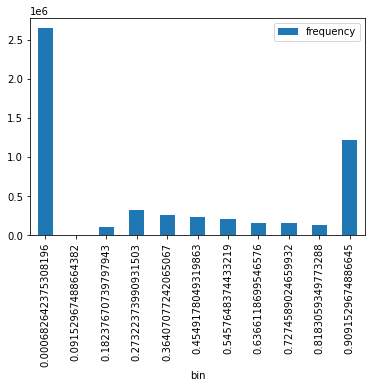

In [21]:
categories_confidence = documents_categories.select('confidence_level').rdd.flatMap(lambda x: x).histogram(11)

pd.DataFrame(
            list(zip(*categories_confidence)),
            columns=['bin', 'frequency']).set_index('bin').plot(kind='bar')

In [90]:
se.sql("""
    SELECT *
    FROM documents_entities
    LIMIT 10
""").toPandas()

,document_id,entity_id,confidence_level
0,1524246,f9eec25663db4cd83183f5c805186f16,0.672865
1,1524246,55ebcfbdaff1d6f60b3907151f38527a,0.399114
2,1524246,839907a972930b17b125eb0247898412,0.392096
3,1524246,04d8f9a1ad48f126d5806a9236872604,0.213996
4,1617787,612a1d17685a498aff4f036c1ee02c16,0.386193
5,1617787,fb8c6cb0879e0de876298177eb1d3fcc,0.364116
6,1617787,793c6a6cf386edb820600d49df045475,0.349168
7,1617787,b525b84d5ed52a34565b8fb870555abe,0.287005
8,1617787,758cb9cb3014607cb4a691cbd485cc94,0.237957
9,1617787,d523aaba6d3916f8b7039fcce0f29639,0.235799


In [97]:
# documents_meta
se.sql("""
    SELECT *
    FROM documents_meta
    WHERE publish_time IS NOT NULL
    LIMIT 10
""").toPandas()

,document_id,source_id,publisher_id,publish_time
0,620150,722,925,2013-01-26 00:00:00
1,623792,722,925,2001-09-15 00:00:00
2,623977,722,925,2002-05-15 00:00:00
3,624657,722,925,2009-10-15 00:00:00
4,624667,722,925,2009-10-15 00:00:00
5,624722,722,925,2009-10-15 00:00:00
6,624743,722,925,2009-10-15 00:00:00
7,624777,722,925,2009-03-15 00:00:00
8,624791,722,925,2002-05-15 00:00:00
9,625257,722,925,2009-10-15 00:00:00


In [6]:
%%time
split_col = F.split(F.substring(documents_meta.publish_time, 1, 10), '-')
documents_meta = documents_meta.withColumn('publish_year', split_col.getItem(0)) \
       .drop(documents_meta.publish_time)
documents_meta.show()
documents_meta.registerTempTable("documents_meta")

+-----------+---------+------------+------------+
|document_id|source_id|publisher_id|publish_year|
+-----------+---------+------------+------------+
|     614868|      722|         925|        null|
|     614869|      722|         925|        null|
|     614870|      722|         925|        null|
|     614871|      722|         925|        null|
|     614872|      722|         925|        null|
|     614873|      722|         925|        null|
|     614874|      722|         925|        null|
|     614875|      722|         925|        null|
|     614876|      722|         925|        null|
|     614877|      722|         925|        null|
|     614879|      722|         925|        null|
|     614880|      722|         925|        null|
|     614881|      722|         925|        null|
|     614882|      722|         925|        null|
|     614883|      722|         925|        null|
|     614885|      722|         925|        null|
|     614886|      722|         925|        null|


In [145]:
# documents_meta
se.sql("""
    SELECT *
    FROM documents_meta
    WHERE publish_year IS NOT NULL
    LIMIT 10
""").toPandas()

,document_id,source_id,publisher_id,publish_year,publish_month,publish_day
0,620150,722,925,2013,01,26
1,623792,722,925,2001,09,15
2,623977,722,925,2002,05,15
3,624657,722,925,2009,10,15
4,624667,722,925,2009,10,15
5,624722,722,925,2009,10,15
6,624743,722,925,2009,10,15
7,624777,722,925,2009,03,15
8,624791,722,925,2002,05,15
9,625257,722,925,2009,10,15


In [127]:
# documents_topics
se.sql("""
    SELECT *
    FROM documents_topics
    LIMIT 10
""").toPandas()

,document_id,topic_id,confidence_level
0,1363957,194,0.071710
1,1363957,102,0.054414
2,1363957,290,0.054014
3,1363957,41,0.038811
4,1363957,196,0.031833
5,1363957,202,0.014734
6,1452655,196,0.106394
7,1452655,200,0.088584
8,1452655,290,0.082351
9,1452655,168,0.051342


In [7]:
split_col = F.split(events['geo_location'], '>')
events = events.withColumn('country', split_col.getItem(0)) \
       .withColumn('state', split_col.getItem(1)) \
       .withColumn('area', split_col.getItem(2)) \
       .drop(events.geo_location)
events.show()

+----------+--------------+-----------+---------+--------+-------+-----+----+
|display_id|          uuid|document_id|timestamp|platform|country|state|area|
+----------+--------------+-----------+---------+--------+-------+-----+----+
|         1|cb8c55702adb93|     379743|       61|       3|     US|   SC| 519|
|         2|79a85fa78311b9|    1794259|       81|       2|     US|   CA| 807|
|         3|822932ce3d8757|    1179111|      182|       2|     US|   MI| 505|
|         4|85281d0a49f7ac|    1777797|      234|       2|     US|   WV| 564|
|         5|8d0daef4bf5b56|     252458|      338|       2|     SG|   00|null|
|         6|7765b4faae4ad4|    1773517|      395|       3|     US|   OH| 510|
|         7|2cc3f6457d16da|    1149661|      602|       2|     US|   MT| 762|
|         8|166fc654d73c98|    1330329|      638|       2|     US|   PA| 566|
|         9|9dddccf70f6067|    1772126|      667|       1|     US|   FL| 528|
|        10|b09a0e92aa4d17|     157455|      693|       1|     U

In [9]:
events = se.sql("""
    SELECT display_id, uuid, document_id, platform,
    hash(country) as country,
    hash(state) as state,
    area
    FROM events
    """)

In [10]:
events.registerTempTable("events")

In [14]:
# events
se.sql("""
    SELECT *
    FROM events
    LIMIT 10
""").toPandas()

,display_id,uuid,document_id,platform,country,state,area
0,1,cb8c55702adb93,379743,3,-1077041708,1448733804,519
1,2,79a85fa78311b9,1794259,2,-1077041708,1886535265,807
2,3,822932ce3d8757,1179111,2,-1077041708,1854557654,505
3,4,85281d0a49f7ac,1777797,2,-1077041708,418063954,564
4,5,8d0daef4bf5b56,252458,2,-524695278,2030285661,None
5,6,7765b4faae4ad4,1773517,3,-1077041708,1054775907,510
6,7,2cc3f6457d16da,1149661,2,-1077041708,-2096415533,762
7,8,166fc654d73c98,1330329,2,-1077041708,410653915,566
8,9,9dddccf70f6067,1772126,1,-1077041708,-1832830425,528
9,10,b09a0e92aa4d17,157455,1,-1077041708,42,None


In [11]:
split_col = F.split(page_views['geo_location'], '>')
page_views = page_views.withColumn('country', split_col.getItem(0)) \
       .withColumn('state', split_col.getItem(1)) \
       .withColumn('area', split_col.getItem(2)) \
       .drop(page_views.geo_location)
page_views.show()
page_views.registerTempTable("page_views")

+--------------+-----------+---------+--------+--------------+-------+-----+----+
|          uuid|document_id|timestamp|platform|traffic_source|country|state|area|
+--------------+-----------+---------+--------+--------------+-------+-----+----+
|68fb8eb72c49c4|    1201414| 63621328|       3|             2|     GB|   F8|null|
|a88f8816ca5830|    1201414| 84129394|       2|             1|     US|   GA| 524|
|fe8feabea9f4dc|    1201414| 18200114|       2|             1|     PK|   04|null|
|23dd0b38da6247|    1201414| 47379374|       2|             2|     NP|   00|null|
|cb7d81b02f4c1b|    1201414| 33703433|       1|             1|     GB|   G5|null|
|ea22c4ad6bbeca|    1201414| 59265600|       3|             2|     GB|   H8|null|
|cb5d44b9a021f2|    1201414| 77977381|       2|             2|     US|   TX| 625|
|2b543e55a6b5c3|    1201414| 72045760|       3|             1|     US|   FL| 528|
|7fe78227bbba60|    1201414| 80636557|       2|             2|     IN|   25|null|
|3ab2db024b9933|

In [19]:
# page_views
se.sql("""
    SELECT uuid, document_id, count(timestamp), min(timestamp), max(timestamp), mean(timestamp)
    FROM page_views
    GROUP BY uuid, document_id
    ORDER BY count(timestamp) DESC
    LIMIT 10
""").toPandas()

,uuid,document_id,count(timestamp),min(timestamp),max(timestamp),mean(timestamp)
0,de23616b89b0be,448345,15,31185862,1240298545,6.365275e+08
1,b550c142306268,448345,15,30175607,1246494108,6.411534e+08
2,8efc158c14e834,448345,15,13975206,1227026351,6.241406e+08
3,4f0b0731bf5e6c,448345,15,32599899,1239896815,6.393809e+08
4,53a1cb33df216a,448345,15,60504394,1263133532,6.594406e+08
5,c180b70eb5993d,448345,15,47962536,1255102452,6.478484e+08
6,380e532372aef5,448345,15,42564366,1255859313,6.520817e+08
7,602b3f4c78d29e,448345,15,75427768,1283479267,6.810942e+08
8,f719a2661ae16b,615200,15,45754178,1258738661,6.560161e+08
9,43a9f6266942f7,266255,15,36549303,1235107553,6.417342e+08


Выцепим из page_views 3 фичи таймстемпов - количство входов в документ со стороны уникального пользователя, разница между первым и последним входом, среднее время входа

Мне кажется, что эти фичи не являются ликом, описанным в приложенной к заданию страничке, поскольку количество входов и остальные значения в целом предопределены, и я не буду пытаться вывести ликовые таймстемпы из словаря таймстемпов, как это сделано в leakage_solution.ipynb

In [12]:
se.sql("""
    SELECT uuid, document_id, count(timestamp) as timestamp_count, 
    max(timestamp)-min(timestamp) as timestamp_interval
    FROM page_views
    GROUP BY uuid, document_id
""").registerTempTable("page_views_agg")

In [101]:
# promoted_content
se.sql("""
    SELECT *
    FROM promoted_content
    LIMIT 10
""").toPandas()

,ad_id,document_id,campaign_id,advertiser_id
0,1,6614,1,7
1,2,471467,2,7
2,3,7692,3,7
3,4,471471,2,7
4,5,471472,2,7
5,6,12736,1,7
6,7,12808,1,7
7,8,471477,2,7
8,9,13379,1,7
9,10,13885,1,7


## Отбор признакового пространства

В качестве объясняющих признаков будем использовать следующие:
1. display_id, ad_id - идентификаторы наблюдения
2. document_id, uuid - идентификаторы пары "документ-пользователь" для каждого display_id
3. timestamp_count \ timestamp_interval \ timestamp_mean - агрегация меток времени из page_views
4. promo_document_id
5. campaign_id
6. advertiser_id
6. platform
7. traffic_source
8. country/state/area и для uuid, и для document_id
9. publisher_id
9. year/month/day для публикаций
10. confidence_level и для entity_id, и для source_id

## Начинаем соединять таблички для подготовки датасета

Начнём с присоединения таблички events

In [27]:
def to_number(raw_value):
    try:
        return float(raw_value)
    except:
        return 0.0
    
se.udf.register("to_number", to_number, "float")

<function __main__.to_number(raw_value)>

Предобработаем таймстемпы и переведём всё в дни по аналогии с бейзлайном, предложенным в задании

In [14]:
train = se.sql(
        """
        SELECT clicks_train.*, events.uuid, events.document_id, \
        events.platform, events.country, events.state, events.area
        FROM clicks_train JOIN events ON clicks_train.display_id == events.display_id
        """)
train.show()

+----------+------+-------+--------------+-----------+--------+-----------+-----------+----+
|display_id| ad_id|clicked|          uuid|document_id|platform|    country|      state|area|
+----------+------+-------+--------------+-----------+--------+-----------+-----------+----+
|       148| 89351|      1|9adce6a5363308|    1205772|       2|-1077041708| 1660582409| 612|
|       148|152140|      0|9adce6a5363308|    1205772|       2|-1077041708| 1660582409| 612|
|       148|152656|      0|9adce6a5363308|    1205772|       2|-1077041708| 1660582409| 612|
|       148|326768|      0|9adce6a5363308|    1205772|       2|-1077041708| 1660582409| 612|
|       463| 28270|      0|85d999a1dd5483|    1787133|       1|-1077041708| -377763884| 764|
|       463| 38813|      1|85d999a1dd5483|    1787133|       1|-1077041708| -377763884| 764|
|       463|104911|      0|85d999a1dd5483|    1787133|       1|-1077041708| -377763884| 764|
|       463|170148|      0|85d999a1dd5483|    1787133|       1|-107704

In [13]:
test = se.sql(
        """
        SELECT clicks_test.*, events.uuid, events.document_id, \
        events.platform, events.country, events.state, events.area
        FROM clicks_test JOIN events ON clicks_test.display_id == events.display_id
        """)
test.show()

+----------+------+--------------+-----------+--------+-----------+----------+----+
|display_id| ad_id|          uuid|document_id|platform|    country|     state|area|
+----------+------+--------------+-----------+--------+-----------+----------+----+
|  16874807|137006|a296494aa7a041|     399863|       2|  899366864|1554269903|null|
|  16874807|192759|a296494aa7a041|     399863|       2|  899366864|1554269903|null|
|  16874807|192855|a296494aa7a041|     399863|       2|  899366864|1554269903|null|
|  16874807|213769|a296494aa7a041|     399863|       2|  899366864|1554269903|null|
|  16874827| 64762|d134b1a0c43628|    1754388|       1|-1077041708|1886535265| 803|
|  16874827|137842|d134b1a0c43628|    1754388|       1|-1077041708|1886535265| 803|
|  16874827|144741|d134b1a0c43628|    1754388|       1|-1077041708|1886535265| 803|
|  16874827|235104|d134b1a0c43628|    1754388|       1|-1077041708|1886535265| 803|
|  16874827|257524|d134b1a0c43628|    1754388|       1|-1077041708|188653526

In [14]:
#train.registerTempTable("train")
test.registerTempTable("test")

Теперь добавим инфу из таблички page_views

In [17]:
train = se.sql(
        """
        SELECT train.*, page_views_agg.timestamp_count, page_views_agg.timestamp_interval
        FROM train LEFT JOIN page_views_agg ON train.uuid == page_views_agg.uuid AND train.document_id == page_views_agg.document_id
        """)
train.show()

+----------+------+-------+--------------+-----------+--------+-----------+----------+----+---------------+------------------+
|display_id| ad_id|clicked|          uuid|document_id|platform|    country|     state|area|timestamp_count|timestamp_interval|
+----------+------+-------+--------------+-----------+--------+-----------+----------+----+---------------+------------------+
|   3749002| 33973|      0|100025359c1e4b|     542474|       3| 1209325285|        42|null|              1|                 0|
|   3749002| 34234|      0|100025359c1e4b|     542474|       3| 1209325285|        42|null|              1|                 0|
|   3749002| 43531|      0|100025359c1e4b|     542474|       3| 1209325285|        42|null|              1|                 0|
|   3749002| 81202|      1|100025359c1e4b|     542474|       3| 1209325285|        42|null|              1|                 0|
|   3749002|200826|      0|100025359c1e4b|     542474|       3| 1209325285|        42|null|              1|    

In [ ]:
print('Количество строчек в тесте -', train.count())
print('Количество дисплеев в тесте -', str(train.select(F.countDistinct("display_id")).collect()[0][0]))
print('Количество реклам в тесте -', str(train.select(F.countDistinct("ad_id")).collect()[0][0]))

Ячейка выше дала на первой строчке такой же результат, как и было изначально, я остановил ячейку, остановил джобы в спарк контексте и скрыл аутпут, чтобы не мучить вас листанием логов keybord interrupt

In [15]:
test = se.sql(
        """
        SELECT test.*, page_views_agg.timestamp_count, page_views_agg.timestamp_interval
        FROM test LEFT JOIN page_views_agg ON test.uuid == page_views_agg.uuid AND test.document_id == page_views_agg.document_id
        """)
test.show()

+----------+------+--------------+-----------+--------+-----------+----------+----+---------------+------------------+
|display_id| ad_id|          uuid|document_id|platform|    country|     state|area|timestamp_count|timestamp_interval|
+----------+------+--------------+-----------+--------+-----------+----------+----+---------------+------------------+
|  21485757|  7033|10012c47f7317b|    2897953|       3|-1077041708|-847081225| 751|              2|           5258911|
|  21485757| 73704|10012c47f7317b|    2897953|       3|-1077041708|-847081225| 751|              2|           5258911|
|  21485757| 85928|10012c47f7317b|    2897953|       3|-1077041708|-847081225| 751|              2|           5258911|
|  21485757|164376|10012c47f7317b|    2897953|       3|-1077041708|-847081225| 751|              2|           5258911|
|  21485757|175592|10012c47f7317b|    2897953|       3|-1077041708|-847081225| 751|              2|           5258911|
|  21485757|184220|10012c47f7317b|    2897953|  

In [16]:
#train.registerTempTable("train")
test.registerTempTable("test")

Теперь добавим данные по предлагаемому контенту и категориальные метки campaign_id, advertiser_id из promoted_content

In [20]:
train = se.sql(
        """
        SELECT train.*, promoted_content.document_id as ad_document_id, \
        promoted_content.campaign_id, promoted_content.advertiser_id
        FROM train LEFT JOIN promoted_content ON train.ad_id == promoted_content.ad_id
        """)
train.show()

+----------+------+-------+--------------+-----------+--------+-----------+----------+----+---------------+------------------+--------------+-----------+-------------+
|display_id| ad_id|clicked|          uuid|document_id|platform|    country|     state|area|timestamp_count|timestamp_interval|ad_document_id|campaign_id|advertiser_id|
+----------+------+-------+--------------+-----------+--------+-----------+----------+----+---------------+------------------+--------------+-----------+-------------+
|   3749002| 33973|      0|100025359c1e4b|     542474|       3| 1209325285|        42|null|              1|                 0|        872253|       4964|         1983|
|   3749002| 34234|      0|100025359c1e4b|     542474|       3| 1209325285|        42|null|              1|                 0|        870875|       4909|         1452|
|   3749002| 43531|      0|100025359c1e4b|     542474|       3| 1209325285|        42|null|              1|                 0|        942981|       4948|       

In [17]:
test = se.sql(
        """
        SELECT test.*, promoted_content.document_id as ad_document_id, \
        promoted_content.campaign_id, promoted_content.advertiser_id
        FROM test LEFT JOIN promoted_content ON test.ad_id == promoted_content.ad_id
        """)
test.show()

+----------+------+--------------+-----------+--------+-----------+----------+----+---------------+------------------+--------------+-----------+-------------+
|display_id| ad_id|          uuid|document_id|platform|    country|     state|area|timestamp_count|timestamp_interval|ad_document_id|campaign_id|advertiser_id|
+----------+------+--------------+-----------+--------+-----------+----------+----+---------------+------------------+--------------+-----------+-------------+
|  21485757|  7033|10012c47f7317b|    2897953|       3|-1077041708|-847081225| 751|              2|           5258911|        393333|        530|          386|
|  21485757| 73704|10012c47f7317b|    2897953|       3|-1077041708|-847081225| 751|              2|           5258911|        205960|       9844|           19|
|  21485757| 85928|10012c47f7317b|    2897953|       3|-1077041708|-847081225| 751|              2|           5258911|       1086097|      11148|         1663|
|  21485757|164376|10012c47f7317b|    28

In [18]:
#train.registerTempTable("train")
test.registerTempTable("test")

In [19]:
print('Количество строчек в тесте -', test.count())

Количество строчек в тесте - 32225162


In [ ]:
# if upper cell != 32225162
print('Количество дисплеев в тесте -', str(clicks_test.select(F.countDistinct("display_id")).collect()[0][0]))
print('Количество реклам в тесте -', str(clicks_test.select(F.countDistinct("ad_id")).collect()[0][0]))

Теперь добавим информацию по документам

In [23]:
train = se.sql(
        """
        SELECT train.*, dm.source_id, dm.publisher_id, dm.publish_year, \
        dt.confidence_level as dt_conf, \
        de.confidence_level as de_conf, \
        dc.confidence_level as dc_conf
        FROM train 
        LEFT JOIN documents_meta dm ON train.document_id == dm.document_id
        LEFT JOIN documents_topics dt ON train.document_id == dt.document_id
        LEFT JOIN documents_entities de ON train.document_id == de.document_id
        LEFT JOIN documents_categories dc ON train.document_id == dc.document_id
        """)
train.show()

+----------+------+-------+--------------+-----------+--------+----------+----------+----+---------------+------------------+--------------+-----------+-------------+---------+------------+------------+------------------+-----------------+-------+
|display_id| ad_id|clicked|          uuid|document_id|platform|   country|     state|area|timestamp_count|timestamp_interval|ad_document_id|campaign_id|advertiser_id|source_id|publisher_id|publish_year|           dt_conf|          de_conf|dc_conf|
+----------+------+-------+--------------+-----------+--------+----------+----------+----+---------------+------------------+--------------+-----------+-------------+---------+------------+------------+------------------+-----------------+-------+
|   7022830|131323|      0|2738bdc48b0b51|        148|       1|1062621904|1297677906|null|              1|                 0|       1225365|      16346|         2988|     1787|         118|        2008|0.0752369712571181|0.632025758366959|   0.92|
|   7022

In [20]:
test = se.sql(
        """
        SELECT test.*, dm.source_id, dm.publisher_id, dm.publish_year, \
        dt.confidence_level as dt_conf, \
        de.confidence_level as de_conf, \
        dc.confidence_level as dc_conf
        FROM test 
        LEFT JOIN documents_meta dm ON test.document_id == dm.document_id
        LEFT JOIN documents_topics dt ON test.document_id == dt.document_id
        LEFT JOIN documents_entities de ON test.document_id == de.document_id
        LEFT JOIN documents_categories dc ON test.document_id == dc.document_id
        """)
test.show()

+----------+------+--------------+-----------+--------+-----------+----------+----+---------------+------------------+--------------+-----------+-------------+---------+------------+------------+-------------------+-------+-----------+
|display_id| ad_id|          uuid|document_id|platform|    country|     state|area|timestamp_count|timestamp_interval|ad_document_id|campaign_id|advertiser_id|source_id|publisher_id|publish_year|            dt_conf|de_conf|    dc_conf|
+----------+------+--------------+-----------+--------+-----------+----------+----+---------------+------------------+--------------+-----------+-------------+---------+------------+------------+-------------------+-------+-----------+
|  18923026| 61159|98884b3a72de24|       1342|       1|-1077041708|1854557654| 553|              1|                 0|        992370|       7283|         1919|      475|         937|        2015| 0.0457308985405448|   null|0.428357428|
|  18923026| 61159|98884b3a72de24|       1342|       1|-

In [31]:
test.show()

+----------+------+--------------+-----------+--------+-----------+-----------+----+---------------+------------------+--------------+-----------+-------------+---------+------------+------------+-------------------+-------+-----------+
|display_id| ad_id|          uuid|document_id|platform|    country|      state|area|timestamp_count|timestamp_interval|ad_document_id|campaign_id|advertiser_id|source_id|publisher_id|publish_year|            dt_conf|de_conf|    dc_conf|
+----------+------+--------------+-----------+--------+-----------+-----------+----+---------------+------------------+--------------+-----------+-------------+---------+------------+------------+-------------------+-------+-----------+
|  21309971|271469|c6028b6abe7e2f|       1342|       1|-1077041708|-1832830425| 539|              1|                 0|       1653374|      27136|         2260|      475|         937|        2015| 0.0457308985405448|   null|0.428357428|
|  21309971|271469|c6028b6abe7e2f|       1342|      

In [29]:
train.columns

['display_id',
 'ad_id',
 'clicked',
 'uuid',
 'document_id',
 'platform',
 'country',
 'state',
 'area',
 'timestamp_count',
 'timestamp_interval',
 'ad_document_id',
 'campaign_id',
 'advertiser_id',
 'source_id',
 'publisher_id',
 'publish_year',
 'dt_conf',
 'de_conf',
 'dc_conf']

In [30]:
test.columns

['display_id',
 'ad_id',
 'uuid',
 'document_id',
 'platform',
 'country',
 'state',
 'area',
 'timestamp_count',
 'timestamp_interval',
 'ad_document_id',
 'campaign_id',
 'advertiser_id',
 'source_id',
 'publisher_id',
 'publish_year',
 'dt_conf',
 'de_conf',
 'dc_conf']

In [21]:
#train.registerTempTable("train")
test.registerTempTable("test")

## Отправка данных в VW

**Спойлер** всё вплоть до следующего заголовка оказалось неактуальным. Я неделю пытался создать датасет с большим количеством фичей, дебажил разные баги, но днём воскресенья после попытки обучить модель на этих 24 фичах у меня начали вылетать логи, свидетельствующие о том, что в некоторых численных фичах (publish_year) есть пропуски, которые почему-то не убрались при вызове df.na.fill(0). В итоге я отправил в мусорку этот датасет на 600гб, предварительно восстановив тетрадку, почищенную от логов на 600к строчек и 200мб веса (запустилась только в notepad++, в бразуере всё плохо и грустно было). Поэтому на своём опыте сделал для себя вывод, что в больших данных нужно аккуратнее относиться к принципу "больше - лучше"

In [39]:
import numpy as np

In [41]:
ids = train.select("display_id").distinct().show()
# возьмём 25% в валидацию, чтобы размеры валидационной и тестовой выборок были примерно равны
ids = np.random.choice(ids, size=len(ids)*0.25, replace=False)

val = train[train.display_id.isin(ids)]
train = train[~train.display_id.isin(ids)]

+----------+
|display_id|
+----------+
|   7409487|
|   1669113|
|   5542913|
|    247014|
|  12181190|
|  16091547|
|   4219541|
|   4172827|
|    481989|
|   6737045|
|   3348231|
|   6246567|
|   9692390|
|   8055831|
|   7213458|
|  12571579|
|   7168341|
|   3938525|
|   6151850|
|  15220669|
+----------+
only showing top 20 rows



TypeError: object of type 'NoneType' has no len()

Разделить выборку на трейн и валидацию с группировкой по дисплею не получилось снахлёсту, поэтому в качестве безлайна воспользуемся простым рандомным разбиением и отнесёмся индиффирентно к тому, что один и тот же дисплей может оказаться и в трейне, и в валидации, ведь по сути мы обучаем модель под задачу классификации, то есть модель должна запомнить какие столбцы уже известных нам признаков лучше дифференцируют вероятность клика по конкретной рекламе.

Если окажется, что в текущих условиях качество будет слишком плохим или наоборот подозрительно хорошим, то вернёмся к задаче группировки по дисплею

In [33]:
train, val = train.randomSplit([.75, .25], 2022)
train, val = train.cache(), val.cache()

In [49]:
train.columns

['display_id',
 'ad_id',
 'clicked',
 'uuid',
 'document_id',
 'day',
 'platform',
 'country',
 'state',
 'area',
 'timestamp_count',
 'timestamp_interval',
 'timestamp_mean',
 'ad_document_id',
 'campaign_id',
 'advertiser_id',
 'source_id',
 'publisher_id',
 'publish_year',
 'topic_id',
 'dt_conf',
 'entity_id',
 'de_conf',
 'category_id',
 'dc_conf']

In [22]:
def convert_to_vw_class(
    data,
    is_train=True):
    data = data.asDict()
    
    tags = 'display_id_'+str(data['display_id'])+'_ad_id_'+str(data['ad_id'])+'|'
        
    # сначала единым namespace добавляем числовые фичи, явно отражая это через :
    
    features = 'numeric time_c:'+str(data['timestamp_count'])+\
                ' time_i:'+str(data['timestamp_interval'])+\
                ' pub_y:'+str(data['publish_year'])+\
                ' dt_c:'+str(data['dt_conf'])[:5]+\
                ' de_c:'+str(data['de_conf'])[:5]+\
                ' dc_c:'+str(data['dc_conf'])[:5]+\
                            ' |a '+str(data['display_id'])+\
                            ' |b '+str(data['ad_id'])+\
                            ' |c '+str(data['uuid'])+\
                            ' |d '+str(data['document_id'])+\
                            ' |e '+str(data['platform'])+\
                            ' |f '+str(data['country'])+\
                            ' |g '+str(data['state'])+\
                            ' |h '+str(data['area'])+\
                            ' |i '+str(data['ad_document_id'])+\
                            ' |j '+str(data['campaign_id'])+\
                            ' |k '+str(data['advertiser_id'])+\
                            ' |l '+str(data['source_id'])+\
                            ' |m '+str(data['publisher_id'])
    
    if is_train:
        if data['clicked'] == 0:
            data['clicked'] = -1
        template = '{target} {tags}{features}'
        return template.format(
            target=data['clicked'], 
            features=features, 
            tags=tags)
    else:
        template = '{tags}{features}'
        return template.format(
                        features=features,
                        tags=tags)

In [36]:
abc = dict(zip(train.columns, range(len(train.columns))))

features = 'numeric time_c:'+str(abc['timestamp_count'])+\
                ' time_i:'+str(abc['timestamp_interval'])+\
                ' pub_y:'+str(abc['publish_year'])+\
                ' dt_c:'+str(abc['dt_conf'])[:5]+\
                ' de_c:'+str(abc['de_conf'])[:5]+\
                ' dc_c:'+str(abc['dc_conf'])[:5]+\
                    ' |a '+str(abc['display_id'])+\
                    ' |b '+str(abc['ad_id'])+\
                    ' |c '+str(abc['uuid'])+\
                    ' |d '+str(abc['document_id'])+\
                    ' |e '+str(abc['platform'])+\
                    ' |f '+str(abc['country'])+\
                    ' |g '+str(abc['state'])+\
                    ' |h '+str(abc['area'])+\
                    ' |i '+str(abc['ad_document_id'])+\
                    ' |j '+str(abc['campaign_id'])+\
                    ' |k '+str(abc['advertiser_id'])+\
                    ' |l '+str(abc['source_id'])+\
                    ' |m '+str(abc['publisher_id'])

features

'numeric time_c:9 time_i:10 pub_y:16 dt_c:17 de_c:18 dc_c:19 |a 0 |b 1 |c 3 |d 4 |e 5 |f 6 |g 7 |h 8 |i 11 |j 12 |k 13 |l 14 |m 15'

In [39]:
print(convert_to_vw_class(abc))

2 display_id_0_ad_id_1|numeric time_c:9 time_i:10 pub_y:16 dt_c:17 de_c:18 dc_c:19  |a 0 |b 1 |c 3 |d 4 |e 5 |f 6 |g 7 |h 8 |i 11 |j 12 |k 13 |l 14 |m 15


In [50]:
%%time
train = train.na.fill(0)
train.registerTempTable("train")

val = val.na.fill(0)
val.registerTempTable("val")

CPU times: user 4.23 ms, sys: 0 ns, total: 4.23 ms
Wall time: 239 ms


In [23]:
test = test.na.fill(0)
test.registerTempTable("test")

In [54]:
%%time
for i in train.take(3):
    print(convert_to_vw_class(i))

-1 display_id_100_ad_id_61159|numeric time_c:1 time_i:0 pub_y:2016 dt_c:0.009 de_c:0.0 dc_c:0.038 |a 100 |b 61159 |c 501c79f343ad29 |d 1717049 |e 1 |f -1077041708 |g 1886535265 |h 825 |i 992370 |j 7283 |k 1919 |l 9606 |m 1066
-1 display_id_100_ad_id_61159|numeric time_c:1 time_i:0 pub_y:2016 dt_c:0.161 de_c:0.0 dc_c:0.501 |a 100 |b 61159 |c 501c79f343ad29 |d 1717049 |e 1 |f -1077041708 |g 1886535265 |h 825 |i 992370 |j 7283 |k 1919 |l 9606 |m 1066
-1 display_id_100_ad_id_149541|numeric time_c:1 time_i:0 pub_y:2016 dt_c:0.009 de_c:0.0 dc_c:0.038 |a 100 |b 149541 |c 501c79f343ad29 |d 1717049 |e 1 |f -1077041708 |g 1886535265 |h 825 |i 1106570 |j 11201 |k 2670 |l 9606 |m 1066
CPU times: user 3.37 ms, sys: 6.01 ms, total: 9.38 ms
Wall time: 31.2 s


In [53]:
import gc
gc.collect()

148

In [44]:
!hdfs dfs -mkdir -p /user/outbrain/vw

In [52]:
! hdfs dfs -rm -r '/user/outbrain/vw/val.vw'
! hdfs dfs -rm -r '/user/outbrain/vw/train.vw'

rm: `/user/outbrain/vw/val.vw': No such file or directory
rm: `/user/outbrain/vw/train.vw': No such file or directory


In [55]:
train.rdd.map(lambda x: convert_to_vw_class(x)).saveAsTextFile('/user/outbrain/vw/train.vw')

In [56]:
val.rdd.map(lambda x: convert_to_vw_class(x)).saveAsTextFile('/user/outbrain/vw/val.vw')

In [24]:
! hdfs dfs -rm -r '/user/outbrain/vw/test.vw'

Deleted /user/outbrain/vw/test.vw


In [25]:
test.rdd.map(lambda x: convert_to_vw_class(x, is_train=False)).saveAsTextFile('/user/outbrain/vw/test.vw')

In [77]:
!yarn application -kill application_1647688802704_0001

2022-03-22 14:10:54,463 INFO client.RMProxy: Connecting to ResourceManager at rc1a-dataproc-m-5qpakob61ma7t4ug.mdb.yandexcloud.net/10.128.0.15:8032
2022-03-22 14:10:54,683 INFO client.AHSProxy: Connecting to Application History server at rc1a-dataproc-m-5qpakob61ma7t4ug.mdb.yandexcloud.net/10.128.0.15:10200
Killing application application_1647688802704_0001
2022-03-22 14:10:55,020 INFO impl.YarnClientImpl: Killed application application_1647688802704_0001


In [49]:
sc.cancelAllJobs()

In [45]:
!hdfs dfs -ls /user/outbrain/vw

Found 2 items
drwxr-xr-x   - ubuntu hadoop          0 2022-03-24 10:58 /user/outbrain/vw/train.vw
drwxr-xr-x   - ubuntu hadoop          0 2022-03-23 11:00 /user/outbrain/vw/val.vw


# Строим модель через VW

In [26]:
%%time
!mkdir ~/bhw/vw

!mkdir ~/bhw/vw/train
!mkdir ~/bhw/vw/val
!mkdir ~/bhw/vw/test

! hdfs dfs -cat '/user/outbrain/vw/train.vw/*' > ~/bhw/vw/train/train.vw
! hdfs dfs -cat '/user/outbrain/vw/val.vw/*' > ~/bhw/vw/val/val.vw
! hdfs dfs -cat '/user/outbrain/vw/test.vw/*' > ~/bhw/vw/test/test.vw

cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to output stream.
cat: Unable to write to o

In [1]:
! sudo wget http://finance.yendor.com/ML/VW/Binaries/vw-8.20190624 -O /usr/bin/vw
! sudo chmod +x /usr/bin/vw
! sudo chown ubuntu /usr/bin/vw

! sudo apt-get update -y && sudo apt-get install graphviz -y
! pip install numpy pandas sklearn dateparser pandarallel ipywidgets catboost graphviz
! /opt/conda/bin/jupyter nbextension enable --py widgetsnbextension

--2022-03-27 12:09:31--  http://finance.yendor.com/ML/VW/Binaries/vw-8.20190624
Resolving finance.yendor.com (finance.yendor.com)... 69.163.152.190
Connecting to finance.yendor.com (finance.yendor.com)|69.163.152.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9467376 (9.0M)
Saving to: ‘/usr/bin/vw’

/usr/bin/vw         100%[===================>]   9.03M  1.15MB/s    in 22s     

2022-03-27 12:09:55 (427 KB/s) - ‘/usr/bin/vw’ saved [9467376/9467376]

Hit:1 http://mirror.yandex.ru/ubuntu focal InRelease
Get:2 http://mirror.yandex.ru/ubuntu focal-updates InRelease [114 kB]          
Hit:3 http://storage.yandexcloud.net/dataproc2x/ci/2-0-alpha-12 focal InRelease
Get:4 http://mirror.yandex.ru/ubuntu focal-backports InRelease [108 kB]        
Get:5 http://mirror.yandex.ru/mirrors/postgresql focal-pgdg InRelease [86.6 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      
Get:7 https://repos.influxdata.com/ubuntu focal InRelease [4,73

In [3]:
import os 

os.environ['PATH'] = '~/.local/bin:' + os.environ['PATH']

In [2]:
# Проверяем, что vw работает
! vw --help 

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1
driver:
  --onethread           Disable parse thread
VW options:
  --ring_size arg (=256, ) size of example ring
  --strict_parse           throw on malformed examples
Update options:
  -l [ --learning_rate ] arg Set learning rate
  --power_t arg              t power value
  --decay_learning_rate arg  Set Decay factor for learning_rate between passes
  --initial_t arg            initial t value
  --feature_mask arg         Use existing regressor to determine which 
                             parameters may be updated.  If no 
                             initial_regressor given, also used for initial 
                             weights.
Weight options:
  -i [ --initial_regressor ] arg  Initial regressor(s)
  --initial_weight arg            Set all weights to an initial value of arg.
  --random_weights                make initial weights random
  --normal_weights  

In [ ]:
%%time
!vw ~/bhw/vw/train/train.vw \
    --final_regressor ~/bhw/vw/outbrain.model_v1.bin \
    --loss_function logistic \
    --learning_rate 20.0 \
    --bit_precision 24 \
    --passes 2 \
    --ftrl --ftrl_alpha 0.05 --ftrl_beta 0.5 --l1 1 \
    --cache -k

using l1 regularization = 1
final_regressor = /home/ubuntu/bhw/vw/outbrain.model_v1.bin
Enabling FTRL based optimization
Algorithm used: Proximal-FTRL
ftrl_alpha = 0.05
ftrl_beta = 0.5
Num weight bits = 24
learning rate = 20
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = /home/ubuntu/bhw/vw/train/train.vw.cache
Reading datafile = /home/ubuntu/bhw/vw/train/train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693147 0.693147            1            1.0  -1.0000   0.0000       18
0.346574 0.000000            2            2.0  -1.0000 -50.0000       18
0.173287 0.000000            4            4.0  -1.0000 -50.0000       18
0.086643 0.000000            8            8.0  -1.0000 -50.0000       18
7.019380 13.952117           16           16.0  -1.0000 -34.4591       18
4.963954 2.908528           32           32.0  -1.0000 -30.0971       18


Дальше было 600к логов об ошибке в формате записи в vw, из-за которых у меня упал джупайтер, не прогружаясь ни в одном браузере (файл стал весить 169мб). Я вручную через notepad почистил эти логи и понял, что надо что-то кардинально менять. Попробуем сделать более легковесные фичи, избавимся от numeric features, как это и было сделано в бейзлайне

## Заново собираем датасет

In [6]:
split_col = F.split(events['geo_location'], '>')
events = events.withColumn('country', split_col.getItem(0)) \
       .withColumn('state', split_col.getItem(1)) \
       .withColumn('area', split_col.getItem(2)) \
       .drop(events.geo_location)
events.show()

+----------+--------------+-----------+---------+--------+-------+-----+----+
|display_id|          uuid|document_id|timestamp|platform|country|state|area|
+----------+--------------+-----------+---------+--------+-------+-----+----+
|         1|cb8c55702adb93|     379743|       61|       3|     US|   SC| 519|
|         2|79a85fa78311b9|    1794259|       81|       2|     US|   CA| 807|
|         3|822932ce3d8757|    1179111|      182|       2|     US|   MI| 505|
|         4|85281d0a49f7ac|    1777797|      234|       2|     US|   WV| 564|
|         5|8d0daef4bf5b56|     252458|      338|       2|     SG|   00|null|
|         6|7765b4faae4ad4|    1773517|      395|       3|     US|   OH| 510|
|         7|2cc3f6457d16da|    1149661|      602|       2|     US|   MT| 762|
|         8|166fc654d73c98|    1330329|      638|       2|     US|   PA| 566|
|         9|9dddccf70f6067|    1772126|      667|       1|     US|   FL| 528|
|        10|b09a0e92aa4d17|     157455|      693|       1|     U

In [7]:
events.registerTempTable("events")

In [8]:
events = se.sql("""
    SELECT display_id, uuid, document_id, platform,
    hash(country) as country,
    hash(state) as state,
    area
    FROM events
    """)

In [9]:
events.registerTempTable("events")

In [10]:
train = se.sql(
        """
        SELECT clicks_train.*, events.uuid, events.document_id, \
        events.platform, events.country, events.state, events.area
        FROM clicks_train LEFT JOIN events ON clicks_train.display_id == events.display_id
        """)
train.show()

+----------+------+-------+--------------+-----------+--------+-----------+-----------+----+
|display_id| ad_id|clicked|          uuid|document_id|platform|    country|      state|area|
+----------+------+-------+--------------+-----------+--------+-----------+-----------+----+
|       148| 89351|      1|9adce6a5363308|    1205772|       2|-1077041708| 1660582409| 612|
|       148|152140|      0|9adce6a5363308|    1205772|       2|-1077041708| 1660582409| 612|
|       148|152656|      0|9adce6a5363308|    1205772|       2|-1077041708| 1660582409| 612|
|       148|326768|      0|9adce6a5363308|    1205772|       2|-1077041708| 1660582409| 612|
|       463| 28270|      0|85d999a1dd5483|    1787133|       1|-1077041708| -377763884| 764|
|       463| 38813|      1|85d999a1dd5483|    1787133|       1|-1077041708| -377763884| 764|
|       463|104911|      0|85d999a1dd5483|    1787133|       1|-1077041708| -377763884| 764|
|       463|170148|      0|85d999a1dd5483|    1787133|       1|-107704

In [11]:
train.registerTempTable("train")

In [12]:
train = se.sql(
        """
        SELECT train.*, promoted_content.document_id as ad_document_id, \
        promoted_content.campaign_id, promoted_content.advertiser_id
        FROM train LEFT JOIN promoted_content ON train.ad_id == promoted_content.ad_id
        """)

In [13]:
train.registerTempTable("train")

In [15]:
train = se.sql(
        """
        SELECT train.*, dm.source_id, dm.publisher_id
        FROM train 
        LEFT JOIN documents_meta dm ON train.document_id == dm.document_id
        """)
train.show()

+----------+------+-------+--------------+-----------+--------+-----------+-----------+----+--------------+-----------+-------------+---------+------------+
|display_id| ad_id|clicked|          uuid|document_id|platform|    country|      state|area|ad_document_id|campaign_id|advertiser_id|source_id|publisher_id|
+----------+------+-------+--------------+-----------+--------+-----------+-----------+----+--------------+-----------+-------------+---------+------------+
|       148| 89351|      1|9adce6a5363308|    1205772|       2|-1077041708| 1660582409| 612|        990613|       7617|         2181|     9135|        1042|
|       148|152140|      0|9adce6a5363308|    1205772|       2|-1077041708| 1660582409| 612|       1060089|      19032|         1593|     9135|        1042|
|       148|152656|      0|9adce6a5363308|    1205772|       2|-1077041708| 1660582409| 612|       1086755|      10511|         2151|     9135|        1042|
|       148|326768|      0|9adce6a5363308|    1205772|    

In [16]:
train.registerTempTable("train")

In [17]:
train, val = train.randomSplit([.75, .25], 2022)
train, val = train.cache(), val.cache()

In [20]:
train = train.fillna(value="0")
val = val.fillna(value="0")

In [19]:
train.columns

['display_id',
 'ad_id',
 'clicked',
 'uuid',
 'document_id',
 'platform',
 'country',
 'state',
 'area',
 'ad_document_id',
 'campaign_id',
 'advertiser_id',
 'source_id',
 'publisher_id']

In [21]:
def convert_to_vw_class(
    data,
    is_train=True):
    data = data.asDict()
    
    tags = 'display_id_'+str(data['display_id'])+'_ad_id_'+str(data['ad_id'])+'|'
        
    # сначала единым namespace добавляем числовые фичи, явно отражая это через :
    
    features =  'a '+str(data['display_id'])+\
                ' |b '+str(data['ad_id'])+\
                ' |c '+str(data['uuid'])+\
                ' |d '+str(data['document_id'])+\
                ' |e '+str(data['platform'])+\
                ' |f '+str(data['country'])+\
                ' |g '+str(data['state'])+\
                ' |h '+str(data['area'])+\
                ' |i '+str(data['ad_document_id'])+\
                ' |j '+str(data['campaign_id'])+\
                ' |k '+str(data['advertiser_id'])+\
                ' |l '+str(data['source_id'])+\
                ' |m '+str(data['publisher_id'])
    
    if is_train:
        if data['clicked'] == 0:
            data['clicked'] = -1
        template = '{target} {tags}{features}'
        return template.format(
            target=data['clicked'], 
            features=features, 
            tags=tags)
    else:
        template = '{tags}{features}'
        return template.format(
                        features=features,
                        tags=tags)

In [18]:
!hdfs dfs -mkdir -p /user/outbrain/vw_v2

In [22]:
train.rdd.map(lambda x: convert_to_vw_class(x)).saveAsTextFile('/user/outbrain/vw_v2/train.vw')

In [23]:
val.rdd.map(lambda x: convert_to_vw_class(x)).saveAsTextFile('/user/outbrain/vw_v2/val.vw')

In [25]:
test = se.sql(
        """
        SELECT clicks_test.*, events.uuid, events.document_id, \
        events.platform, events.country, events.state, events.area
        FROM clicks_test LEFT JOIN events ON clicks_test.display_id == events.display_id
        """)
test.show()

+----------+------+--------------+-----------+--------+-----------+----------+----+
|display_id| ad_id|          uuid|document_id|platform|    country|     state|area|
+----------+------+--------------+-----------+--------+-----------+----------+----+
|  16874807|137006|a296494aa7a041|     399863|       2|  899366864|1554269903|null|
|  16874807|192759|a296494aa7a041|     399863|       2|  899366864|1554269903|null|
|  16874807|192855|a296494aa7a041|     399863|       2|  899366864|1554269903|null|
|  16874807|213769|a296494aa7a041|     399863|       2|  899366864|1554269903|null|
|  16874827| 64762|d134b1a0c43628|    1754388|       1|-1077041708|1886535265| 803|
|  16874827|137842|d134b1a0c43628|    1754388|       1|-1077041708|1886535265| 803|
|  16874827|144741|d134b1a0c43628|    1754388|       1|-1077041708|1886535265| 803|
|  16874827|235104|d134b1a0c43628|    1754388|       1|-1077041708|1886535265| 803|
|  16874827|257524|d134b1a0c43628|    1754388|       1|-1077041708|188653526

In [26]:
test.registerTempTable("test")
test = se.sql(
        """
        SELECT test.*, promoted_content.document_id as ad_document_id, \
        promoted_content.campaign_id, promoted_content.advertiser_id
        FROM test LEFT JOIN promoted_content ON test.ad_id == promoted_content.ad_id
        """)

In [ ]:
test.registerTempTable("test")


In [27]:
test.registerTempTable("test")
test = se.sql(
        """
        SELECT test.*, dm.source_id, dm.publisher_id
        FROM test 
        LEFT JOIN documents_meta dm ON test.document_id == dm.document_id
        """)
test.show()

+----------+------+--------------+-----------+--------+-----------+----------+----+--------------+-----------+-------------+---------+------------+
|display_id| ad_id|          uuid|document_id|platform|    country|     state|area|ad_document_id|campaign_id|advertiser_id|source_id|publisher_id|
+----------+------+--------------+-----------+--------+-----------+----------+----+--------------+-----------+-------------+---------+------------+
|  16874807|137006|a296494aa7a041|     399863|       2|  899366864|1554269903|null|        916403|      17587|          859|     7633|          27|
|  16874807|192759|a296494aa7a041|     399863|       2|  899366864|1554269903|null|       1469601|      22742|         1975|     7633|          27|
|  16874807|192855|a296494aa7a041|     399863|       2|  899366864|1554269903|null|       1460834|      22748|          622|     7633|          27|
|  16874807|213769|a296494aa7a041|     399863|       2|  899366864|1554269903|null|        903092|      23770|  

In [28]:
test = test.fillna(value="0")

In [29]:
test.rdd.map(lambda x: convert_to_vw_class(x, is_train=False)).saveAsTextFile('/user/outbrain/vw_v2/test.vw')

In [32]:
!ls ~/bhw/vw

test  train  val


In [33]:
!rm -r ~/bhw/vw

In [35]:
!ls ~/bhw

spark-warehouse


In [36]:
!mkdir ~/bhw/vw

!mkdir ~/bhw/vw/train
!mkdir ~/bhw/vw/val
!mkdir ~/bhw/vw/test

! hdfs dfs -cat '/user/outbrain/vw_v2/train.vw/*' > ~/bhw/vw/train/train.vw
! hdfs dfs -cat '/user/outbrain/vw_v2/val.vw/*' > ~/bhw/vw/val/val.vw
! hdfs dfs -cat '/user/outbrain/vw_v2/test.vw/*' > ~/bhw/vw/test/test.vw

## Обучаем логрегу

In [37]:
%%time
!vw ~/bhw/vw/train/train.vw \
    --final_regressor ~/bhw/vw/outbrain.model_v1.bin \
    --loss_function logistic \
    --learning_rate 20.0 \
    --bit_precision 24 \
    --passes 2 \
    --ftrl --ftrl_alpha 0.05 --ftrl_beta 0.5 --l1 1 \
    --cache -k

using l1 regularization = 1
final_regressor = /home/ubuntu/bhw/vw/outbrain.model_v1.bin
Enabling FTRL based optimization
Algorithm used: Proximal-FTRL
ftrl_alpha = 0.05
ftrl_beta = 0.5
Num weight bits = 24
learning rate = 20
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = /home/ubuntu/bhw/vw/train/train.vw.cache
Reading datafile = /home/ubuntu/bhw/vw/train/train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693147 0.693147            1            1.0   1.0000   0.0000       14
0.693147 0.693147            2            2.0  -1.0000   0.0000       14
0.693147 0.693147            4            4.0   1.0000   0.0000       14
0.684064 0.674980            8            8.0  -1.0000  -0.1510       14
0.672962 0.661860           16           16.0  -1.0000  -0.1158       14
0.682371 0.691780           32           32.0  -1.0000  -0.1708       14
0.6681

In [39]:
!vw --testonly --link=logistic \
    --initial_regressor ~/bhw/vw/outbrain.model_v1.bin \
    --predictions ~/bhw/vw/val_prediction_v1.txt \
    ~/bhw/vw/val/val.vw

only testing
predictions = /home/ubuntu/bhw/vw/val_prediction_v1.txt
Enabling FTRL based optimization
Algorithm used: Proximal-FTRL
ftrl_alpha = 0.005
ftrl_beta = 0.1
Num weight bits = 24
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = /home/ubuntu/bhw/vw/val/val.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.195177 0.195177            1            1.0  -1.0000   0.1913       14
2.369281 4.543385            2            2.0  -1.0000   0.0418       14
3.076195 3.783109            4            4.0  -1.0000   0.0231       14
2.455558 1.834921            8            8.0  -1.0000   0.1385       14
2.341125 2.226693           16           16.0  -1.0000   0.2446       14
2.210193 2.079261           32           32.0   1.0000   0.0938       14
2.456861 2.703530           64           64.0  -1.0000   0.1847       14
2.267317 2.077773         

Попробуем добавить некоторые взаимодействия рассматриваемых категориальных признаков

In [41]:
%%time
for i in val.take(3):
    print(convert_to_vw_class(i))

-1 display_id_148_ad_id_152140|a 148 |b 152140 |c 9adce6a5363308 |d 1205772 |e 2 |f -1077041708 |g 1660582409 |h 612 |i 1060089 |j 19032 |k 1593 |l 9135 |m 1042
-1 display_id_148_ad_id_152656|a 148 |b 152656 |c 9adce6a5363308 |d 1205772 |e 2 |f -1077041708 |g 1660582409 |h 612 |i 1086755 |j 10511 |k 2151 |l 9135 |m 1042
-1 display_id_463_ad_id_170148|a 463 |b 170148 |c 85d999a1dd5483 |d 1787133 |e 1 |f -1077041708 |g -377763884 |h 764 |i 1368736 |j 20922 |k 473 |l 7478 |m 874
CPU times: user 6.56 ms, sys: 0 ns, total: 6.56 ms
Wall time: 224 ms


'a '+str(data['display_id'])+\
' |b '+str(data['ad_id'])+\
' |c '+str(data['uuid'])+\
' |d '+str(data['document_id'])+\
' |e '+str(data['platform'])+\
' |f '+str(data['country'])+\
' |g '+str(data['state'])+\
' |h '+str(data['area'])+\
' |i '+str(data['ad_document_id'])+\
' |j '+str(data['campaign_id'])+\
' |k '+str(data['advertiser_id'])+\
' |l '+str(data['source_id'])+\
' |m '+str(data['publisher_id'])

In [43]:
%%time
!vw ~/bhw/vw/train/train.vw \
    --initial_regressor ~/bhw/vw/outbrain.model_v1.bin \
    --final_regressor ~/bhw/vw/outbrain.model_v2.bin \
    --loss_function logistic \
    --learning_rate 0.05 \
    --bit_precision 24 \
    --passes 5 \
    --ftrl --ftrl_alpha 0.05 --ftrl_beta 0.5 --l1 1 \
    --interactions ab bc di fg jk \
    --cache -k

creating features for following interactions: ab bc di fg jk 
using l1 regularization = 1
final_regressor = /home/ubuntu/bhw/vw/outbrain.model_v2.bin
Enabling FTRL based optimization
Algorithm used: Proximal-FTRL
ftrl_alpha = 0.05
ftrl_beta = 0.5
Num weight bits = 24
learning rate = 0.05
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = /home/ubuntu/bhw/vw/train/train.vw.cache
Reading datafile = /home/ubuntu/bhw/vw/train/train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.913786 0.913786            1            1.0   1.0000  -0.4013       19
0.848590 0.783393            2            2.0  -1.0000   0.1730       19
0.582158 0.315726            4            4.0   1.0000   0.2950       19
0.479777 0.377396            8            8.0  -1.0000  -0.0688       19
0.474504 0.469230           16           16.0  -1.0000  -0.9205       19
0.535069 0.5956

In [44]:
!vw --testonly --link=logistic \
    --initial_regressor ~/bhw/vw/outbrain.model_v2.bin \
    --predictions ~/bhw/vw/val_prediction_v2.txt \
    ~/bhw/vw/val/val.vw

creating features for following interactions: ab bc di fg jk 
only testing
predictions = /home/ubuntu/bhw/vw/val_prediction_v2.txt
Enabling FTRL based optimization
Algorithm used: Proximal-FTRL
ftrl_alpha = 0.005
ftrl_beta = 0.1
Num weight bits = 24
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = /home/ubuntu/bhw/vw/val/val.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.023586 0.023586            1            1.0  -1.0000   0.3002       19
2.292644 4.561702            2            2.0  -1.0000   0.0417       19
2.914731 3.536818            4            4.0  -1.0000   0.0251       19
2.383913 1.853095            8            8.0  -1.0000   0.1409       19
2.263642 2.143370           16           16.0  -1.0000   0.2358       19
2.202601 2.141560           32           32.0   1.0000   0.0922       19
2.450248 2.697896           64       

# Делаем файл submission для Kaggle

In [40]:
%%time
!vw --testonly --link=logistic \
    --initial_regressor ~/bhw/vw/outbrain.model_v1.bin \
    --predictions ~/bhw/vw/test_submisiion_v1.txt \
    ~/bhw/vw/test/test.vw

only testing
predictions = /home/ubuntu/bhw/vw/test_submisiion_v1.txt
Enabling FTRL based optimization
Algorithm used: Proximal-FTRL
ftrl_alpha = 0.005
ftrl_beta = 0.1
Num weight bits = 24
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = /home/ubuntu/bhw/vw/test/test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown   0.2094       14
    n.a.     n.a.            2            2.0  unknown   0.1601       14
    n.a.     n.a.            4            4.0  unknown   0.2038       14
    n.a.     n.a.            8            8.0  unknown   0.1265       14
    n.a.     n.a.           16           16.0  unknown   0.3327       14
    n.a.     n.a.           32           32.0  unknown   0.0424       14
    n.a.     n.a.           64           64.0  unknown   0.0789       14
    n.a.     n.a.      

In [45]:
%%time
!vw --testonly --link=logistic \
    --initial_regressor ~/bhw/vw/outbrain.model_v2.bin \
    --predictions ~/bhw/vw/test_submisiion_v2.txt \
    ~/bhw/vw/test/test.vw

creating features for following interactions: ab bc di fg jk 
only testing
predictions = /home/ubuntu/bhw/vw/test_submisiion_v2.txt
Enabling FTRL based optimization
Algorithm used: Proximal-FTRL
ftrl_alpha = 0.005
ftrl_beta = 0.1
Num weight bits = 24
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = /home/ubuntu/bhw/vw/test/test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown   0.1986       19
    n.a.     n.a.            2            2.0  unknown   0.1616       19
    n.a.     n.a.            4            4.0  unknown   0.2004       19
    n.a.     n.a.            8            8.0  unknown   0.1387       19
    n.a.     n.a.           16           16.0  unknown   0.2848       19
    n.a.     n.a.           32           32.0  unknown   0.0440       19
    n.a.     n.a.           64    

In [6]:
import pandas as pd
import numpy as np

def convert_from_vw(vw_record):
        line = {'clicked': float(vw_record.split(' ')[0]),
                'display_id': int(vw_record.split('_')[2]),
                'ad_id': int(vw_record.split('_')[5])}        
        return line
    
def convert_to_kaggle(vw_preds, kaggle_preds, prob=0.0001):    
    
    output = {'clicked': [], 'display_id': [], 'ad_id': []}
    with open(vw_preds, 'r') as f:
        for i, line in enumerate(f):
            for k, v in convert_from_vw(line).items():
                output[k].append(v)
            if i % 10000000 == 0:
                print('i =', i)
    print('Формирование словаря завершено, переводим в пандас')
    output = pd.DataFrame(output)

    output_csv = output.sort_values(['display_id', 'clicked'], ascending=False)\
                    .groupby('display_id')\
                    .agg(list).reset_index()
    
    print('Сортировка и группировка датафрейма завершена, форматируем и сохраняем')
    output_csv['ad_id'] = output_csv.apply(lambda x: ' '.join(np.array(x.ad_id)\
                        [np.array(x.clicked)>=prob].astype(str)), axis=1)

    output_csv[['display_id', 'ad_id']].to_csv(kaggle_preds, index=False)
    
    return output

In [49]:
!mkdir ~/bhw/vw/submission
!ls ~/bhw/vw/

outbrain.model_v1.bin  test_submisiion_v1.txt  val_prediction_v1.txt
outbrain.model_v2.bin  test_submisiion_v2.txt  val_prediction_v2.txt
submission	       train
test		       val


In [8]:
!cat ~/bhw/vw/test_submisiion_v1.txt | head -n 10 > sample_vw_sub.txt

cat: write error: Broken pipe


In [10]:
!cat sample_vw_sub.txt

0.209384 display_id_16874807_ad_id_137006
0.160140 display_id_16874807_ad_id_192759
0.239949 display_id_16874807_ad_id_192855
0.203847 display_id_16874807_ad_id_213769
0.170838 display_id_16874827_ad_id_64762
0.203823 display_id_16874827_ad_id_137842
0.260659 display_id_16874827_ad_id_144741
0.126464 display_id_16874827_ad_id_235104
0.134684 display_id_16874827_ad_id_257524
0.058718 display_id_16874838_ad_id_37887


In [58]:
!realpath ~/bhw/vw/test_submisiion_v1.txt

/home/ubuntu/bhw/vw/test_submisiion_v1.txt


In [30]:
%%time
output = convert_to_kaggle('/home/ubuntu/sample_vw_sub.txt',
                           '/home/ubuntu/sample_submission.csv')

i = 0
Формирование словаря завершено, переводим в пандас
CPU times: user 11.4 ms, sys: 0 ns, total: 11.4 ms
Wall time: 9.48 ms


In [15]:
! cat sample_submission.csv

display_id,ad_id
16874807,137006 192759 192855 213769
16874827,64762 137842 144741 235104 257524
16874838,37887


In [31]:
output = output.sort_values(['display_id', 'clicked'], ascending=False)\
                    .groupby('display_id')[['ad_id', 'clicked']]\
                    .agg(list).reset_index()

output['ad_id'] = output.apply(lambda x: ' '.join(np.array(x.ad_id)\
                        [np.array(x.clicked)>=0.01].astype(str)), axis=1)

output

,display_id,ad_id,clicked
0,16874807,192855 137006 213769 192759,"[0.239949, 0.209384, 0.203847, 0.16014]"
1,16874827,144741 137842 64762 257524 235104,"[0.260659, 0.203823, 0.170838, 0.134684, 0.126..."
2,16874838,37887,[0.058718]


Забыл добавить сортировку в функцию, смотрим изменение быстродействия на subsample, проверяем корректность сортировки

In [33]:
%%time
output = convert_to_kaggle('/home/ubuntu/sample_vw_sub.txt',
                           '/home/ubuntu/sample_submission.csv')

i = 0
Формирование словаря завершено, переводим в пандас
Сортировка и группировка датафрейма завершена, форматируем и сохраняем
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 10.2 ms


In [34]:
! cat sample_submission.csv

display_id,ad_id
16874807,192855 137006 213769 192759
16874827,144741 137842 64762 257524 235104
16874838,37887


До добавления сортировки ячейка ниже отрабатывала за 8 минут, посмотрим сколько будет теперь

In [36]:
%%time
output = convert_to_kaggle('/home/ubuntu/bhw/vw/test_submisiion_v1.txt',
                           '/home/ubuntu/bhw/vw/submission/sub_v1_sort.csv')

i = 0
i = 10000000
i = 20000000
i = 30000000
Формирование словаря завершено, переводим в пандас
Сортировка и группировка датафрейма завершена, форматируем и сохраняем
CPU times: user 8min 17s, sys: 14.2 s, total: 8min 31s
Wall time: 8min 32s


In [37]:
! kaggle competitions submit -c outbrain-click-prediction -f ~/bhw/vw/submission/sub_v1_sort.csv -m "ver_1_sort"

100%|████████████████████████████████████████| 260M/260M [00:10<00:00, 25.8MB/s]
Successfully submitted to Outbrain Click Prediction

In [38]:
%%time
output = convert_to_kaggle('/home/ubuntu/bhw/vw/test_submisiion_v2.txt',
                           '/home/ubuntu/bhw/vw/submission/sub_v2_sort.csv')

i = 0
i = 10000000
i = 20000000
i = 30000000
Формирование словаря завершено, переводим в пандас
Сортировка и группировка датафрейма завершена, форматируем и сохраняем
CPU times: user 8min 17s, sys: 15 s, total: 8min 32s
Wall time: 8min 33s


In [39]:
! kaggle competitions submit -c outbrain-click-prediction -f ~/bhw/vw/submission/sub_v2_sort.csv -m "ver_2_sort"

100%|████████████████████████████████████████| 260M/260M [00:11<00:00, 24.1MB/s]
Successfully submitted to Outbrain Click Prediction

Это решение выдало качество 0.50332 на прайвате - постараемся подбить ещё что-нибудь, чтобы хоть чуть-чуть приблизиться к 0.64 и получить 4 за бдз

In [29]:
%%time
!vw ~/bhw/vw/train/train.vw \
    --initial_regressor ~/bhw/vw/outbrain.model_v2.bin \
    --final_regressor ~/bhw/vw/outbrain.model_v3.bin \
    --loss_function logistic \
    --learning_rate 0.05 \
    --bit_precision 24 \
    --passes 2 \
    --ftrl --ftrl_alpha 0.05 --ftrl_beta 0.5 --l1 1 \
    --interactions ab ac ad ae af ag ah ai aj ak al bc bd be bf bg bh bi bj bk bl cd ce cf cg ch ci cj ck cl de df dg dh di dj dk dl ef eg eh ei ej ek el fg fh fi fj fk fl gh gi gj gk gl hi hj hk hl ij ik il jk jl kl \
    --cache -k

creating features for following interactions: ab ac ad ae af ag ah ai aj ak al bc bd be bf bg bh bi bj bk bl cd ce cf cg ch ci cj ck cl de df dg dh di dj dk dl ef eg eh ei ej ek el fg fh fi fj fk fl gh gi gj gk gl hi hj hk hl ij ik il jk jl kl 
using l1 regularization = 1
final_regressor = /home/ubuntu/bhw/vw/outbrain.model_v3.bin
Enabling FTRL based optimization
Algorithm used: Proximal-FTRL
ftrl_alpha = 0.05
ftrl_beta = 0.5
Num weight bits = 24
learning rate = 0.05
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = /home/ubuntu/bhw/vw/train/train.vw.cache
Reading datafile = /home/ubuntu/bhw/vw/train/train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.178954 1.178954            1            1.0   1.0000  -0.8114       80
0.906865 0.634775            2            2.0  -1.0000  -0.1204       80
0.647531 0.388197            4            4.0   1.0

In [30]:
%%time
!vw --testonly --link=logistic \
    --initial_regressor ~/bhw/vw/outbrain.model_v3.bin \
    --predictions ~/bhw/vw/test_submisiion_v3.txt \
    ~/bhw/vw/test/test.vw

creating features for following interactions: ab ac ad ae af ag ah ai aj ak al bc bd be bf bg bh bi bj bk bl cd ce cf cg ch ci cj ck cl de df dg dh di dj dk dl ef eg eh ei ej ek el fg fh fi fj fk fl gh gi gj gk gl hi hj hk hl ij ik il jk jl kl 
only testing
predictions = /home/ubuntu/bhw/vw/test_submisiion_v3.txt
Enabling FTRL based optimization
Algorithm used: Proximal-FTRL
ftrl_alpha = 0.005
ftrl_beta = 0.1
Num weight bits = 24
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = /home/ubuntu/bhw/vw/test/test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown   0.4929       80
    n.a.     n.a.            2            2.0  unknown   0.2044       80
    n.a.     n.a.            4            4.0  unknown   0.3295       80
    n.a.     n.a.            8            8.0  unknown   0.2617       

In [40]:
%%time
output = convert_to_kaggle('/home/ubuntu/bhw/vw/test_submisiion_v3.txt',
                           '/home/ubuntu/bhw/vw/submission/sub_v3_sort.csv')

i = 0
i = 10000000
i = 20000000
i = 30000000
Формирование словаря завершено, переводим в пандас
Сортировка и группировка датафрейма завершена, форматируем и сохраняем
CPU times: user 8min 15s, sys: 14.7 s, total: 8min 29s
Wall time: 8min 31s


In [41]:
! kaggle competitions submit -c outbrain-click-prediction -f ~/bhw/vw/submission/sub_v3_sort.csv -m "ver_3_sort"

100%|████████████████████████████████████████| 260M/260M [00:11<00:00, 24.4MB/s]
Successfully submitted to Outbrain Click Prediction

In [2]:
%%time
!vw ~/bhw/vw/train/train.vw \
    --initial_regressor ~/bhw/vw/outbrain.model_v3.bin \
    --final_regressor ~/bhw/vw/outbrain.model_v4.bin \
    --loss_function logistic \
    --learning_rate 0.05 \
    --bit_precision 24 \
    --passes 2 \
    --ftrl --ftrl_alpha 0.05 --ftrl_beta 0.5 --l1 1 \
    --interactions bc bd be bf bg bh bi bj bk bl cd ce cf cg ch ci cj ck cl de df dg dh di dj dk dl ef eg eh ei ej ek el fg fh fi fj fk fl gh gi gj gk gl hi hj hk hl ij ik il jk jl kl \
    --nn 3 \
    --inpass \
    --cache -k

creating features for following interactions: bc bd be bf bg bh bi bj bk bl cd ce cf cg ch ci cj ck cl de df dg dh di dj dk dl ef eg eh ei ej ek el fg fh fi fj fk fl gh gi gj gk gl hi hj hk hl ij ik il jk jl kl 
using l1 regularization = 1
final_regressor = /home/ubuntu/bhw/vw/outbrain.model_v4.bin
using input passthrough for neural network training
Enabling FTRL based optimization
Algorithm used: Proximal-FTRL
ftrl_alpha = 0.05
ftrl_beta = 0.5
Num weight bits = 24
learning rate = 0.05
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = /home/ubuntu/bhw/vw/train/train.vw.cache
Reading datafile = /home/ubuntu/bhw/vw/train/train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.980940 0.980940            1            1.0   1.0000  -0.5110       69
0.721879 0.462818            2            2.0  -1.0000  -0.5301       69
0.677507 0.633134            4  

In [3]:
%%time
!vw --testonly --link=logistic \
    --initial_regressor ~/bhw/vw/outbrain.model_v4.bin \
    --predictions ~/bhw/vw/test_submisiion_v4.txt \
    ~/bhw/vw/test/test.vw

creating features for following interactions: bc bd be bf bg bh bi bj bk bl cd ce cf cg ch ci cj ck cl de df dg dh di dj dk dl ef eg eh ei ej ek el fg fh fi fj fk fl gh gi gj gk gl hi hj hk hl ij ik il jk jl kl 
only testing
predictions = /home/ubuntu/bhw/vw/test_submisiion_v4.txt
using input passthrough for neural network testing
Enabling FTRL based optimization
Algorithm used: Proximal-FTRL
ftrl_alpha = 0.005
ftrl_beta = 0.1
Num weight bits = 24
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = /home/ubuntu/bhw/vw/test/test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown   0.3482       69
    n.a.     n.a.            2            2.0  unknown   0.1437       69
    n.a.     n.a.            4            4.0  unknown   0.2378       69
    n.a.     n.a.            8            8.0  unkno

In [42]:
%%time
output = convert_to_kaggle('/home/ubuntu/bhw/vw/test_submisiion_v4.txt',
                           '/home/ubuntu/bhw/vw/submission/sub_v4_sort.csv')

i = 0
i = 10000000
i = 20000000
i = 30000000
Формирование словаря завершено, переводим в пандас
Сортировка и группировка датафрейма завершена, форматируем и сохраняем
CPU times: user 8min 13s, sys: 13.6 s, total: 8min 26s
Wall time: 8min 26s


In [43]:
! kaggle competitions submit -c outbrain-click-prediction -f ~/bhw/vw/submission/sub_v4_sort.csv -m "ver_4_sort"

100%|████████████████████████████████████████| 260M/260M [00:10<00:00, 25.2MB/s]
Successfully submitted to Outbrain Click Prediction

После последовательного обучения 4 моделей VW качество в 0.655 позволяет претендовать на 6 за БДЗ и 7 за курс, ура! Но попробуем добить до 0.67, чтобы получить итоговую 8

## Результирующая метрика

* Обучаем логрегу вероятности клика, решая задачу бинарной классификации, оптимизируемся по логлоссу
* После этого группировка по display_id и сортировка по ad_id по вероятности клика
* Дальше для каждого display_id считаем AP@K: если ad_id на первой позиции, то выдаём ему 1, если на 2, то 1/2 и так далее до 1/12. Если в топ-12 нет, то 0
* Потом суммируем все значения AP@K для каждого display_id и делим на количество этих display_id

In [5]:
# код из одной из тетрадок с Kaggle
df_test['prob'] = df_test[['fixed_timestamp','ad_id']].apply(lambda x: get_prob(x),axis=1)
subm = df_test.groupby("display_id").agg({'ad_id': agg2arr, 'prob': agg2arr})
subm['ad_id'] = subm[['ad_id','prob']].apply(lambda x: val_sort(x),axis=1)
del subm['prob']
subm.to_csv("subm_leak.csv")

NameError: name 'df_test' is not defined

In [28]:
!cat ~/bhw/vw/val_prediction_v1.txt | head -n 10

0.191269 display_id_148_ad_id_152140
0.041826 display_id_148_ad_id_152656
0.239227 display_id_463_ad_id_170148
0.023063 display_id_463_ad_id_221782
0.049578 display_id_463_ad_id_327054
0.236219 display_id_496_ad_id_44460
0.064410 display_id_496_ad_id_124745
0.138499 display_id_1088_ad_id_204056
0.148716 display_id_1088_ad_id_331398
0.192680 display_id_1238_ad_id_116212
cat: write error: Broken pipe


In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true, y_pred)

Я хотел считать roc-auc и map@12 на валидации для каждой посылки, но когда понял, что у нас неограниченное количество посылок, то решил, что валидация здесь в целом не нужна и можно исходить из предпосылки, что на таком большом количестве сэмплов переобучения не будет, особенно при должной регуляризации весов. Это подтверждается тем фактом, что каждая следующая посылка из 4 моделей выше обладала всё большим качеством на прайвате

Поэтому можно добавить в модель информацию из выделенного под валидацию куска данных с надеждой на дополнительное увеличение качества, сравнивая только результат на Kaggle (Понимаю, что по уму следовало всё-таки оставить валидацию и считать метрики до посылки, но раз ситуация позволяет, почему бы этим не воспользоваться)

In [1]:
%%time
!vw ~/bhw/vw/val/val.vw \
    --initial_regressor ~/bhw/vw/outbrain.model_v4.bin \
    --final_regressor ~/bhw/vw/outbrain.model_v5.bin \
    --loss_function logistic \
    --learning_rate 0.1 \
    --bit_precision 24 \
    --passes 3 \
    --ftrl --ftrl_alpha 0.01 --ftrl_beta 0.1 --l1 1 \
    --interactions ab ac ad ae af ag ah ai aj ak al bc bd be bf bg bh bi bj bk bl cd ce cf cg ch ci cj ck cl de df dg dh di dj dk dl ef eg eh ei ej ek el fg fh fi fj fk fl gh gi gj gk gl hi hj hk hl ij ik il jk jl kl \
    --nn 3 \
    --inpass \
    --cache -k

creating features for following interactions: ab ac ad ae af ag ah ai aj ak al bc bd be bf bg bh bi bj bk bl cd ce cf cg ch ci cj ck cl de df dg dh di dj dk dl ef eg eh ei ej ek el fg fh fi fj fk fl gh gi gj gk gl hi hj hk hl ij ik il jk jl kl 
using l1 regularization = 1
final_regressor = /home/ubuntu/bhw/vw/outbrain.model_v5.bin
using input passthrough for neural network training
Enabling FTRL based optimization
Algorithm used: Proximal-FTRL
ftrl_alpha = 0.01
ftrl_beta = 0.1
Num weight bits = 24
learning rate = 0.1
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = /home/ubuntu/bhw/vw/val/val.vw.cache
Reading datafile = /home/ubuntu/bhw/vw/val/val.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.326625 0.326625            1            1.0  -1.0000  -0.9512       80
0.201141 0.075657            2            2.0  -1.0000  -2.5435       80
0.217875

In [2]:
%%time
!vw --testonly --link=logistic \
    --initial_regressor ~/bhw/vw/outbrain.model_v5.bin \
    --predictions ~/bhw/vw/test_submisiion_v5.txt \
    ~/bhw/vw/test/test.vw

creating features for following interactions: ab ac ad ae af ag ah ai aj ak al bc bd be bf bg bh bi bj bk bl cd ce cf cg ch ci cj ck cl de df dg dh di dj dk dl ef eg eh ei ej ek el fg fh fi fj fk fl gh gi gj gk gl hi hj hk hl ij ik il jk jl kl 
only testing
predictions = /home/ubuntu/bhw/vw/test_submisiion_v5.txt
using input passthrough for neural network testing
Enabling FTRL based optimization
Algorithm used: Proximal-FTRL
ftrl_alpha = 0.005
ftrl_beta = 0.1
Num weight bits = 24
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = /home/ubuntu/bhw/vw/test/test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown   0.4062       80
    n.a.     n.a.            2            2.0  unknown   0.3467       80
    n.a.     n.a.            4            4.0  unknown   0.5527       80
    n.a.     n.a.  

In [10]:
%%time
output = convert_to_kaggle('/home/ubuntu/bhw/vw/test_submisiion_v5.txt',
                           '/home/ubuntu/bhw/vw/submission/sub_v5_sort.csv')

i = 0
i = 10000000
i = 20000000
i = 30000000
Формирование словаря завершено, переводим в пандас
Сортировка и группировка датафрейма завершена, форматируем и сохраняем
CPU times: user 8min 35s, sys: 12.7 s, total: 8min 47s
Wall time: 8min 47s


In [11]:
! kaggle competitions submit -c outbrain-click-prediction -f ~/bhw/vw/submission/sub_v5_sort.csv -m "ver_5_sort"

100%|████████████████████████████████████████| 260M/260M [00:10<00:00, 25.7MB/s]
Successfully submitted to Outbrain Click Prediction

Качество стало хуже самой первой отсортированной посылки, попробую объединить трейн и вал, чтобы веса не переобучались под 20% выборки, что очевидно произошло в данном случае

In [24]:
!ls ~/bhw/vw

outbrain.model_v1.bin  test		       train
outbrain.model_v2.bin  test_submisiion_v1.txt  val
outbrain.model_v3.bin  test_submisiion_v2.txt  val_prediction_v1.txt
outbrain.model_v4.bin  test_submisiion_v3.txt  val_prediction_v2.txt
outbrain.model_v5.bin  test_submisiion_v4.txt
submission	       test_submisiion_v5.txt


In [23]:
!du ~/bhw/vw/submission/sub_v1.csv

244856	/home/ubuntu/bhw/vw/submission/sub_v1.csv


In [25]:
!mkdir ~/bhw/vw/wide_train/

In [28]:
!cat ~/bhw/vw/train/train.vw ~/bhw/vw/val/val.vw > ~/bhw/vw/wide_train/wide_train.vw

In [29]:
%%time
!vw ~/bhw/vw/wide_train/wide_train.vw \
    --initial_regressor ~/bhw/vw/outbrain.model_v4.bin \
    --final_regressor ~/bhw/vw/outbrain.model_v6.bin \
    --loss_function logistic \
    --learning_rate 0.1 \
    --bit_precision 24 \
    --passes 3 \
    --ftrl --ftrl_alpha 0.01 --ftrl_beta 0.1 --l1 1 \
    --interactions ab ac ad ae af ag ah ai aj ak al bc bd be bf bg bh bi bj bk bl cd ce cf cg ch ci cj ck cl de df dg dh di dj dk dl ef eg eh ei ej ek el fg fh fi fj fk fl gh gi gj gk gl hi hj hk hl ij ik il jk jl kl \
    --nn 3 \
    --inpass \
    --cache -k

creating features for following interactions: ab ac ad ae af ag ah ai aj ak al bc bd be bf bg bh bi bj bk bl cd ce cf cg ch ci cj ck cl de df dg dh di dj dk dl ef eg eh ei ej ek el fg fh fi fj fk fl gh gi gj gk gl hi hj hk hl ij ik il jk jl kl 
using l1 regularization = 1
final_regressor = /home/ubuntu/bhw/vw/outbrain.model_v6.bin
using input passthrough for neural network training
Enabling FTRL based optimization
Algorithm used: Proximal-FTRL
ftrl_alpha = 0.01
ftrl_beta = 0.1
Num weight bits = 24
learning rate = 0.1
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = /home/ubuntu/bhw/vw/wide_train/wide_train.vw.cache
Reading datafile = /home/ubuntu/bhw/vw/wide_train/wide_train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.952331 0.952331            1            1.0   1.0000  -0.4648       80
0.622361 0.292391            2            2.0  -1.000

In [30]:
%%time
!vw --testonly --link=logistic \
    --initial_regressor ~/bhw/vw/outbrain.model_v6.bin \
    --predictions ~/bhw/vw/test_submisiion_v6.txt \
    ~/bhw/vw/test/test.vw

creating features for following interactions: ab ac ad ae af ag ah ai aj ak al bc bd be bf bg bh bi bj bk bl cd ce cf cg ch ci cj ck cl de df dg dh di dj dk dl ef eg eh ei ej ek el fg fh fi fj fk fl gh gi gj gk gl hi hj hk hl ij ik il jk jl kl 
only testing
predictions = /home/ubuntu/bhw/vw/test_submisiion_v6.txt
using input passthrough for neural network testing
Enabling FTRL based optimization
Algorithm used: Proximal-FTRL
ftrl_alpha = 0.005
ftrl_beta = 0.1
Num weight bits = 24
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = /home/ubuntu/bhw/vw/test/test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown   0.3750       80
    n.a.     n.a.            2            2.0  unknown   0.2299       80
    n.a.     n.a.            4            4.0  unknown   0.2913       80
    n.a.     n.a.  

In [31]:
%%time
output = convert_to_kaggle('/home/ubuntu/bhw/vw/test_submisiion_v6.txt',
                           '/home/ubuntu/bhw/vw/submission/sub_v6_sort.csv')

i = 0
i = 10000000
i = 20000000
i = 30000000
Формирование словаря завершено, переводим в пандас
Сортировка и группировка датафрейма завершена, форматируем и сохраняем
CPU times: user 8min 30s, sys: 16.6 s, total: 8min 47s
Wall time: 8min 46s


In [32]:
! kaggle competitions submit -c outbrain-click-prediction -f ~/bhw/vw/submission/sub_v6_sort.csv -m "ver_6_sort"

100%|████████████████████████████████████████| 260M/260M [00:10<00:00, 26.5MB/s]
Successfully submitted to Outbrain Click Prediction

Данная посылка дала результат на private в 0.65589, немного не дотягивает до 7 за эту БДЗ, но в целом приемлемо.

[Подтверждение получения качества 0.65589](https://storage.yandexcloud.net/bucket-zolotarev-bst/bhw_kaggle_2.PNG)

## Итоги

[Скриншот посылки в Kaggle](https://storage.yandexcloud.net/bucket-zolotarev-bst/bhw_kaggle.PNG)

Тезисно:
* нужно внимательнее и аккуратнее обрабатывать данные, чтобы не тратить неделю на глупые ошибки и выбивание по нехватке памяти при сборе датасета
* в больших данных нужно научиться грамотно строить фичи после предварительного анализа структуры данных на небольшом самсэмпле
* не всегда нужно максимизировать количество фичей, потому что это может привести к созданию огромных датасетов на сотни ГБ, которые даже vw не может обработать
* нужно аккуратно реализовывать конвертацию в требуемые форматы, чтобы логи ворнингов не убивали тетрадку
* порой достаточно просто реализовать уже придуманный кем-то бейзлайн и рандомно потыкать разные архитектуры state-of-the-art с последовательным дообучением модели

По курсу:
* всё было классно и приятно, за исключением вечных багов и вылетов по памяти
* надеюсь полученные знания принесут мне тыщи миллионов в будущем